<a href="https://colab.research.google.com/github/vmartinezarias/Curso_Ecologia_Paisaje_y-Ecoacustica/blob/main/7_Autocorrelaci%C3%B3n_Espacial_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Autocorrelación espacial
En este script se van a manejar:

## **I de morán**:

Es el índice más común para medir la autocorrelación espacial. Moran's I evalúa si los valores similares están más cercanos espacialmente de lo que sería aleatorio. Su valor devaría entre:
1: Autocorrelación espacial positiva perfecta (valores similares están cerca unos de otros).
0: No hay autocorrelación espacial (aleatoriedad espacial).
-1: Autocorrelación espacial negativa perfecta (valores disímiles están cerca unos de otros).

Adicionalmente, se maneja un p-value, el cuál si está por encima de 0.05 no se puede rechazar la Hipótesis Nula de que NO hay auto correlción espacial.

### 1. Instalación de paquetes

In [ ]:
!pip install rasterio
!pip install geopandas
!pip install libpysal
!pip install esda
!pip install shapely
!pip install splot
!pip install pysal


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.8/379.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.4/347.4 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59

### 2. Carga de paquetes, conexión a carpeta de drive y carga de archivos base

In [ ]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.sample import sample_gen
import libpysal as ps
from esda.moran import Moran
import matplotlib.pyplot as plt
from shapely.geometry import Point
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Rutas de los archivos
shapefile_path = '/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Muestreo.shp'
raster_path = '/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/NDVI.tif'


### 3. Carga de puntos de muestreo y capa de variable, realización del sampling
En este caso, se va a usar el NDVI, sin embargo si en el shp original se cuenta con variables, éste código puede también ser adaptado. Si esto último es el caso, pasar directamente al 4to punto.

In [ ]:
# Carga de puntos de muestreo y raster NDVI
puntos_muestreo = gpd.read_file(shapefile_path)
# Verificación del CRS
with rasterio.open(raster_path) as src:
    raster_crs = src.crs
puntos_muestreo = puntos_muestreo.to_crs(raster_crs)
# Realizar el "sampling" de NDVI para cada punto
with rasterio.open(raster_path) as src:
    coords = [(geom.x, geom.y) for geom in puntos_muestreo.geometry]
    sampled_values = [val[0] for val in src.sample(coords)]

# Agregar los valores NDVI a los puntos de muestreo
puntos_muestreo['NDVI'] = sampled_values

# Filtrar puntos con valores NDVI válidos (descartar NaN o valores fuera de rango)
puntos_muestreo = puntos_muestreo[~np.isnan(puntos_muestreo['NDVI'])]
print(puntos_muestreo.head())

### 4. Creación de Matriz de Pesos espaciales basados en proximidad, y  cálculo de la I de Morán.

En el anterior punto, se han creado datos a partir de un muestreo del NDVI basándonos en la ubicación de las grabadoras. Sin embargo, si ya se cuenta con datos preliminares, en el siguiente chunk se puede cambiar el nombre de NDVI por el de la columna con la información deseada.

In [ ]:
# Crear la matriz de pesos espaciales basada en la proximidad
coordinates = np.array([(geom.x, geom.y) for geom in puntos_muestreo.geometry])
weights = ps.weights.DistanceBand.from_array(coordinates, threshold=1000, binary=True)  # Distancia en metros

# Calcular Moran's I para NDVI
ndvi_values = puntos_muestreo['NDVI'].values
moran = Moran(ndvi_values, weights)

# Mostrar resultados
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")

### 5. Visualización de Clústers

In [ ]:
# Visualizar clusters
plt.figure(figsize=(10, 6))
plt.scatter(puntos_muestreo.geometry.x, puntos_muestreo.geometry.y, c=puntos_muestreo['NDVI'], cmap='viridis', s=50)
plt.colorbar(label="NDVI")
plt.title("Puntos de muestreo con valores de NDVI")
plt.xlabel("Coordenadas X")
plt.ylabel("Coordenadas Y")
plt.show()


## Lisa

### 1 Importe de librerías

In [ ]:
#!pip install rasterio
#!pip install geopandas
#!pip install libpysal
#!pip install esda
#!pip install shapely
#!pip install splot
#!pip install pysal

import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from splot.esda import plot_local_autocorrelation
from pysal.lib import weights
from pysal.explore import esda
from google.colab import drive

### 2 Conexión a Drive, carga de puntos de muestreo y capa de variable

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

# Rutas de archivos
puntos_filepath = '/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Muestreo.shp'
raster_filepath = '/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/NDVI.tif'

# Cargar los puntos de muestreo
puntos_muestreo = gpd.read_file(puntos_filepath)

Mounted at /content/drive


### 3 Crear matriz de pesos espaciales, estandarización, cálculo de LISA

In [ ]:
# Leer los valores de NDVI en los puntos de muestreo
with rasterio.open(raster_filepath) as src:
    puntos_muestreo['ndvi'] = [
        next(src.sample([(point.x, point.y)]))[0] for point in puntos_muestreo.geometry
    ]

# Remover puntos con valores NDVI no válidos (e.g., nodata)
puntos_muestreo = puntos_muestreo[~puntos_muestreo['ndvi'].isnull()]

# Asegurar que la columna 'ndvi' es de tipo float64
puntos_muestreo['ndvi'] = puntos_muestreo['ndvi'].astype(np.float64)

# Crear una matriz de pesos espaciales basada en la vecindad de distancias (threshold 1000 metros)
w = weights.DistanceBand.from_dataframe(puntos_muestreo, threshold=1000, binary=True, silence_warnings=True)

# Estandarizar los pesos
w.transform = 'R'

# Calcular LISA (Local Moran's I)
lisa = esda.Moran_Local(puntos_muestreo['ndvi'], w)

# Agregar resultados de LISA al GeoDataFrame
puntos_muestreo['lisa_cluster'] = lisa.q
puntos_muestreo['lisa_pvalue'] = lisa.p_sim
puntos_muestreo['lisa_Is'] = lisa.Is

# Definir etiquetas para los clusters
clusters = {
    1: "Alto-Alto",
    2: "Bajo-Bajo",
    3: "Alto-Bajo",
    4: "Bajo-Alto"
}
puntos_muestreo['cluster_label'] = puntos_muestreo['lisa_cluster'].map(clusters)


### 4 Resultados de LISA

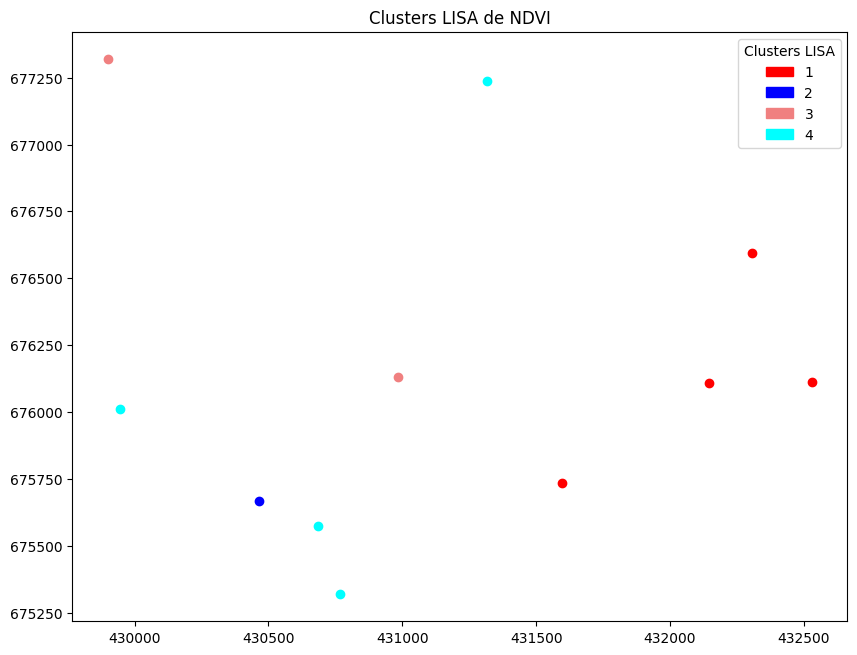

     Site           x           y   ndvi  lisa_cluster  lisa_Is  lisa_pvalue
0   LEJ04 429899.6842 677320.9074 0.5264             3  -0.0000       0.0010
5   LEM01 431318.0346 677235.8308 0.8052             4   0.0000       0.0010
8   LEN02 432147.2843 676108.5796 0.7887             1   0.3477       0.1280
1   LEJ05 429943.8166 676010.6121 0.7474             4  -0.1599       0.1420
9   LEO01 432305.9755 676593.3259 0.7442             1   0.1368       0.2310
7   LEM04 431597.9097 675734.1789 0.8211             1   0.1788       0.2350
3   LEK06 430767.4967 675319.3453 0.7769             4  -0.1625       0.2690
4   LEL03 430686.6332 675575.1785 0.7918             4  -0.1496       0.2970
10  LEO02 432531.3177 676111.3834 0.8043             1   0.2846       0.3830
2   LEK05 430465.1685 675670.3046 0.4863             2  -0.2382       0.4190
6   LEM03 430984.0476 676131.8243 0.6184             3   0.0009       0.4350


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Definir colores y etiquetas para los clusters
cluster_colors = {
    1: 'red',    # Alto-Alto (HH)
    2: 'blue',   # Bajo-Bajo (LL)
    3: 'lightcoral',   # Alto-Bajo (HL)
    4: 'cyan'    # Bajo-Alto (LH)
}
cluster_labels = {
    1: "HH (Alto-Alto)",
    2: "LL (Bajo-Bajo)",
    3: "HL (Alto-Bajo)",
    4: "LH (Bajo-Alto)"
}

# Mapear colores y etiquetas al GeoDataFrame
puntos_muestreo['color'] = puntos_muestreo['lisa_cluster'].map(cluster_colors)
puntos_muestreo['label'] = puntos_muestreo['lisa_cluster'].map(cluster_labels)

# Visualización de los resultados
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Graficar cada punto con su color y mostrar p-value en la leyenda
for cluster, color in cluster_colors.items():
    puntos_cluster = puntos_muestreo[puntos_muestreo['lisa_cluster'] == cluster]
    puntos_cluster.plot(ax=ax, color=color, label=f"{cluster_labels[cluster]} (p < 0.05)" if (puntos_cluster['lisa_pvalue'] < 0.05).any() else cluster_labels[cluster])

# Añadir leyenda descriptiva
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in cluster_colors.items()]
ax.legend(handles=legend_patches, title="Clusters LISA", loc="upper right")

plt.title("Clusters LISA de NDVI")
plt.show()

# Mostrar tabla de resultados con los valores significativos de LISA en la consola
import pandas as pd

# Crear un DataFrame con los resultados clave de LISA
resultados_lisa = puntos_muestreo[['Site', 'x', 'y', 'ndvi', 'lisa_cluster', 'lisa_Is', 'lisa_pvalue']].copy()

# Ordenar por p-value para identificar los puntos más significativos
resultados_lisa = resultados_lisa.sort_values(by='lisa_pvalue')

# Mostrar la tabla en la consola
pd.set_option('display.float_format', lambda x: f'{x:.4f}')  # Formato para floats
print(resultados_lisa)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


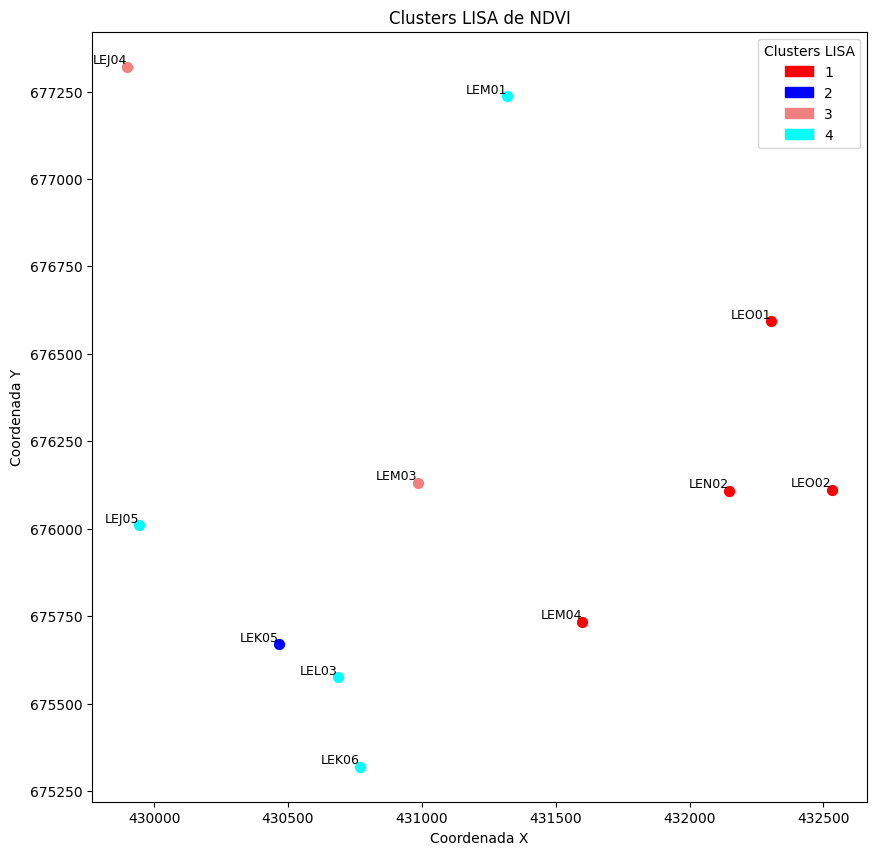

Archivo Excel guardado en: /content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica/Resultados/resultados_lisa.xlsx


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import pandas as pd
import os
from google.colab import drive

# Montar Google Drive para almacenar el archivo Excel
drive.mount('/content/drive')

# Definir la ruta para guardar el archivo Excel
main_folder_path = '/content/drive/MyDrive/Curso_Ecologia_Paisaje_Ecoacustica'
results_folder_path = os.path.join(main_folder_path, "Resultados")
os.makedirs(results_folder_path, exist_ok=True)
excel_path = os.path.join(results_folder_path, 'resultados_lisa.xlsx')

# Definir colores y etiquetas para los clusters
cluster_colors = {
    1: 'red',    # Alto-Alto (HH)
    2: 'blue',   # Bajo-Bajo (LL)
    3: 'lightcoral',   # Alto-Bajo (HL)
    4: 'cyan'    # Bajo-Alto (LH)
}
cluster_labels = {
    1: "HH (Alto-Alto)",
    2: "LL (Bajo-Bajo)",
    3: "HL (Alto-Bajo)",
    4: "LH (Bajo-Alto)"
}

# Mapear colores y etiquetas al GeoDataFrame
puntos_muestreo['color'] = puntos_muestreo['lisa_cluster'].map(cluster_colors)
puntos_muestreo['label'] = puntos_muestreo['lisa_cluster'].map(cluster_labels)

# Visualización de los resultados
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Graficar cada punto con su color y agregar etiquetas de "Site"
for idx, row in puntos_muestreo.iterrows():
    ax.scatter(row['x'], row['y'], color=row['color'], s=50, label=row['label'] if idx == 0 else "")
    ax.text(row['x'], row['y'], row['Site'], fontsize=9, ha='right', va='bottom')

# Añadir leyenda descriptiva
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in cluster_colors.items()]
ax.legend(handles=legend_patches, title="Clusters LISA", loc="upper right")

plt.title("Clusters LISA de NDVI")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.show()

# Crear un DataFrame con los resultados clave de LISA y guardar en Excel
resultados_lisa = puntos_muestreo[['Site', 'x', 'y', 'ndvi', 'lisa_cluster', 'lisa_Is', 'lisa_pvalue']].copy()
resultados_lisa['Cluster_Label'] = resultados_lisa['lisa_cluster'].map(cluster_labels)

# Ordenar por p-value para identificar los puntos más significativos
resultados_lisa = resultados_lisa.sort_values(by='lisa_pvalue')

# Guardar el DataFrame en un archivo Excel
with pd.ExcelWriter(excel_path) as writer:
    resultados_lisa.to_excel(writer, sheet_name='LISA Results', index=False)

print(f"Archivo Excel guardado en: {excel_path}")
